In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
#load images
noncarSources = glob.glob('./train_images/non-vehicles/*/*.png')
carSources = glob.glob('./train_images/vehicles/*/*.png')

noncarImages = []
carImages = []

for index in range(0,len(noncarSources)):
    noncarImages.append(mpimg.imread(noncarSources[index]))
    
for index in range(0,len(carSources)):
    carImages.append(mpimg.imread(carSources[index]))

In [3]:
class Feature:
    
    length = 32
    
    def __init__(self, length = 32):
        self.length = length
        
    def getFeatures(self,image):
        image_features = []
        image_features.append(self.getBinSpatialFeatures(image))
        image_features.append(self.getHistogramFeatures(image))
        image_features.append(self.getHogFeatures(image))
        
        return np.hstack(image_features)

    def getBinSpatialFeatures(self, image):
        image = cv2.resize(image, (self.length, self.length), interpolation=cv2.INTER_CUBIC)
        return np.hstack((image[:,:,0].ravel(), image[:,:,1].ravel(), image[:,:,2].ravel()))
    
    def getHistogramFeatures(self, image):
        nbins = self.length
        histogram_features = []
        histogram_features.append(np.histogram(image[:,:,0], bins=nbins)[0])
        histogram_features.append(np.histogram(image[:,:,1], bins=nbins)[0])
        histogram_features.append(np.histogram(image[:,:,2], bins=nbins)[0])
                
        return np.concatenate(histogram_features)
    
    def showHogFeatures(self, channel, orient = 17, pix_per_cell = 8, cell_per_block = 2, 
                        visualise=True, feature_vector=True):
        _, hogImage = hog(channel, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=False, 
                           visualise=visualise, 
                           feature_vector=feature_vector)

        return hogImage
    
    def getHogFeatures(self, image, orient = 17, pix_per_cell = 8, cell_per_block = 2, 
                        visualise=False, feature_vector=True):
        hogFeatures = []
        
        for channel in range(image.shape[2]):
             hogFeatures.append(hog(image[:,:,channel], orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=False, 
                           visualise=visualise, 
                           feature_vector=feature_vector).ravel()
                       )
                
        return np.hstack(hogFeatures)

In [4]:
class ImageList:
    
    imageList = []
    preprocessedList = []
    features = []
    featureMachine = Feature()
    
    def setImageList(self, images):
        self.imageList = images
    
    def addImage(self, image):
        self.imageList.append(image)
        
    def addImage(self, image):
        self.imageList.append(image)
        
    def toHsv(self, image):
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    def toHls(self, image):
        return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    def toYCrCb (self, image):
        return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
    def preprocess(self, image):
        return self.toYCrCb(image)
    
    def preprocessAll(self):
        self.preprocessedList = []
        for image in self.imageList:
            self.preprocessedList.append(self.preprocess(image))
            
    def getAllFeatures(self):
        self.features = []
        for image in self.preprocessedList:
            self.features.append(self.featureMachine.getFeatures(image))

In [5]:
class Trainer:
    svc = object
    X_scaler = object
    
    def train(self, features):
        X = self.features = np.vstack((features)).astype(np.float64)
        self.X_scaler = StandardScaler().fit(X)
        scaled_X = self.X_scaler.transform(X)
        
        y = np.hstack((np.ones(len(features[0])), np.zeros(len(features[1]))))

        X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.33, random_state=None)
        
        self.svc = LinearSVC()
        self.svc.fit(X_train, y_train)
        
        return self.svc.score(X_test, y_test)

In [6]:
class Detector:
    image = []
    startPoint = [0,0]
    size = 64
    step = 64
    featureMachine = Feature()
    svc = object
    scaler = object
    rectangles = []
    labels = []
    
    def __init__(self, svc, scaler, size=64):
        self.svc = svc
        self.scaler = scaler
        self.size = size
    
    def setImage(self, image):
        self.image =  cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb).astype(np.float32)/255
    
    def getBorders(self):
        #check x
        if (self.startPoint[1]+self.size + self.step <= self.image.shape[1]):
            self.startPoint[1] = self.startPoint[1] + self.step
        #check y
        elif (self.startPoint[0]+self.size + self.step <= self.image.shape[0]):
            self.startPoint[1] = 0
            self.startPoint[0] = self.startPoint[0] + self.step
        else:
            self.startPoint = None
    
    def find(self):
        rectangles = []
        for length in range(128,32,-32):
            self.startPoint = [400, 0]
            self.step = np.int(length/2)
            while (self.startPoint != None):
                window = self.image[self.startPoint[0]:self.startPoint[0]+length,
                                   self.startPoint[1]:self.startPoint[1]+length]
                
                hogFeatures = []
                singleFeatures = self.featureMachine.getFeatures(
                                                            cv2.resize(window, 
                                                                       (self.size, self.size),
                                                                       interpolation=cv2.INTER_CUBIC))
                hogFeatures.append(singleFeatures)
                
                reshaped = np.array(hogFeatures).reshape(-1,1)
                predictionFeed = self.scaler.transform(hogFeatures)

                prediction = self.svc.predict(predictionFeed)

                if prediction == 1:
                    rectangles.append(
                                ((np.int(self.startPoint[1]), np.int(self.startPoint[0])),
                                (np.int((self.startPoint[1]+length)),np.int((self.startPoint[0]+length))))
                    )
                    
                    self.step = np.int(length/10)
                else:
                    if self.step < length/2:
                        self.step = np.int(self.step+(length/2))
                self.getBorders()
        self.rectangles = rectangles
    
    def getHeatmap(self, thresh=5):
            drawing = np.copy(self.image)
            for rectangle in self.rectangles:
                cv2.rectangle(drawing, rectangle[0], rectangle[1], (255,0,0), 2)
            heatmap = np.zeros_like(drawing[:,:,0]).astype(np.float)
            for rectangle in self.rectangles:
                heatmap[rectangle[0][1]:rectangle[1][1], rectangle[0][0]:rectangle[1][0]] += 1
            heatmap[heatmap <= thresh] = 0
            self.labels = label(heatmap)
            return self.labels
        
    def drawBox(self, original):
        for carCount in range(1, self.labels[1]+1):
            nonzero = (self.labels[0] == carCount).nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            singleBox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            cv2.rectangle(original, singleBox[0], singleBox[1], (255,0,0), 3)
        return original

In [7]:
noncarImageList = np.random.shuffle(noncarImages)
carImageList = np.random.shuffle(carImages)

carImageList = ImageList()
carImageList.setImageList(carImages)

noncarImageList = ImageList()
noncarImageList.setImageList(noncarImages)

carImageList.preprocessAll()
noncarImageList.preprocessAll()

carImageList.getAllFeatures()
noncarImageList.getAllFeatures()

trainer = Trainer()

accuracy = trainer.train([carImageList.features, noncarImageList.features])

print('Accuracy:', round(accuracy, 4))

Accuracy: 0.9899


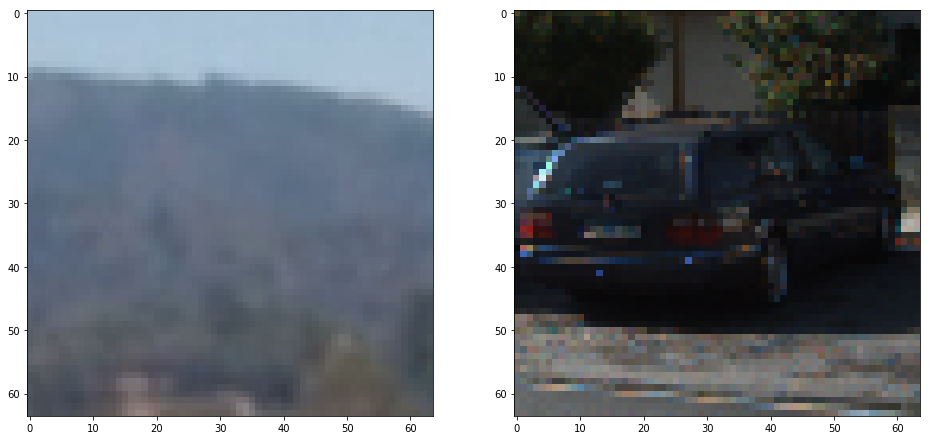

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16,14))
axs[0].imshow(noncarImageList.imageList[5])
axs[1].imshow(carImageList.imageList[5])

In [9]:
sampleImage = carImageList.imageList[5]
prepImage = carImageList.preprocess(sampleImage)

In [10]:
feature = Feature()
binSpatialFeatures = feature.getBinSpatialFeatures(prepImage)
histogramFeatures = feature.getHistogramFeatures(prepImage)
hogFeatures = feature.getHogFeatures(prepImage)

(-0.5, 63.5, 63.5, -0.5)

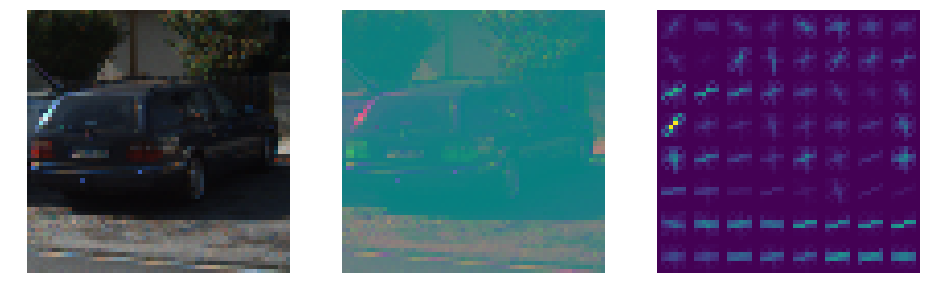

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(16,14))
axs[0].imshow(sampleImage)
axs[0].axis('off')
axs[1].imshow(prepImage)
axs[1].axis('off')
axs[2].imshow(feature.showHogFeatures(prepImage[:,:,0]))
axs[2].axis('off')

In [12]:
testImage = mpimg.imread('./test_images/test4.jpg')
detector = Detector(trainer.svc, trainer.X_scaler)
detector.setImage(testImage)
detector.find()

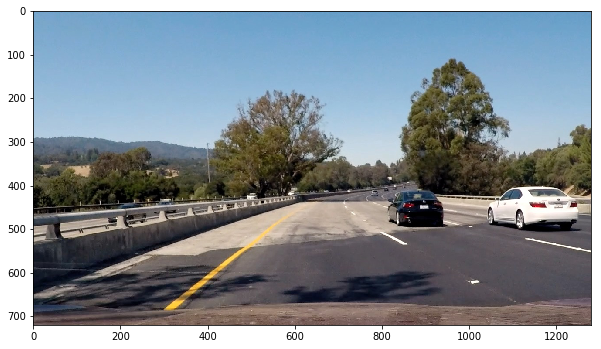

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(testImage)

In [14]:
drawing = np.copy(testImage)
for rectangle in detector.rectangles:
    cv2.rectangle(drawing, rectangle[0], rectangle[1], (255,0,0), 2)

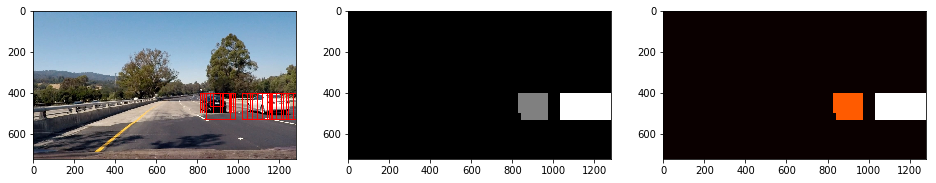

In [15]:
heatmap = detector.getHeatmap(1)

fig, axs = plt.subplots(1, 3, figsize=(16,14))
axs[0].imshow(drawing)
axs[1].imshow(heatmap[0], cmap='gray')
axs[2].imshow(heatmap[0], cmap='hot')

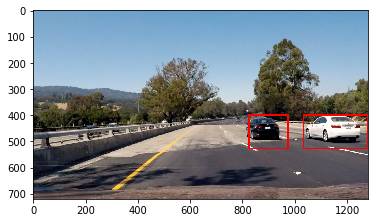

In [16]:
boxedImage = detector.drawBox(testImage)
plt.imshow(boxedImage)

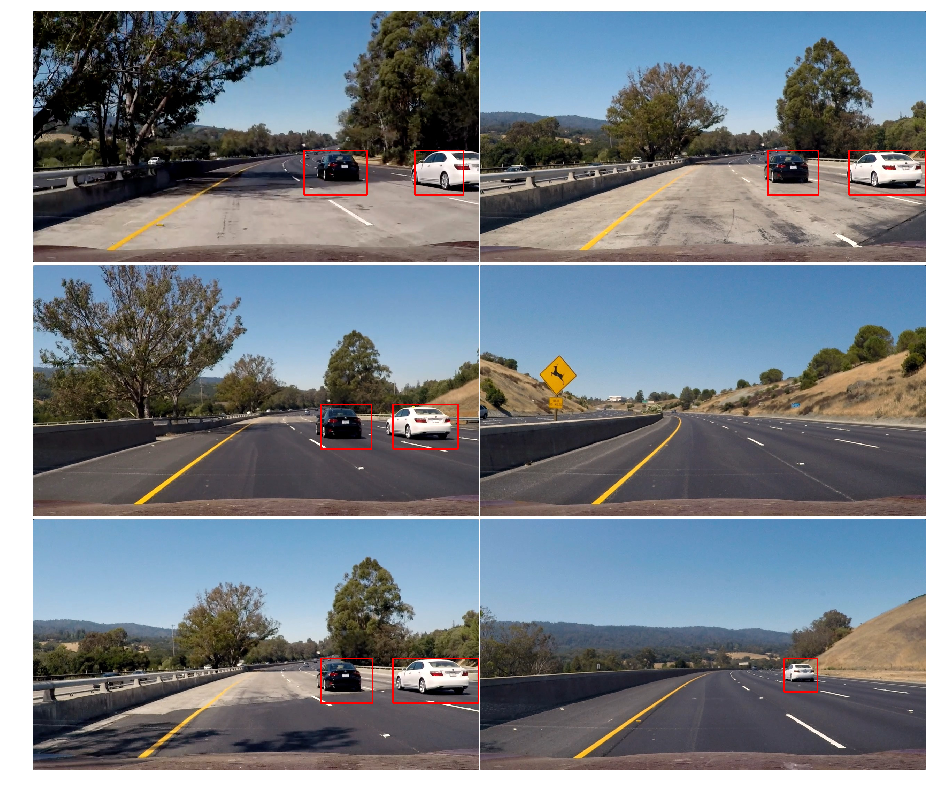

In [17]:
testList = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

detector = Detector(trainer.svc, trainer.X_scaler)

for i, imagefile in enumerate(testList):
    image = mpimg.imread(imagefile)
    detector.setImage(image)
    detector.find()
    detector.getHeatmap(1)
    boxedImage = detector.drawBox(image)
    axs[i].imshow(boxedImage)
    axs[i].axis('off')

In [18]:
def processFrame(image):
    detector = Detector(trainer.svc, trainer.X_scaler)
    detector.setImage(image)    
    detector.find()
    detector.getHeatmap(1)
    return detector.drawBox(image)

test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(processFrame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [1:22:38<00:03,  3.98s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1h 23min 13s, sys: 2.23 s, total: 1h 23min 16s
Wall time: 1h 22min 39s
